In [1]:
import scipy as scipy
from multiprocessing import Queue
import sklearn
import pandas as pd
import numpy as np
import datetime
from PIL import Image # to open images
import os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import shutil
from setup import loss_curve_plot, accuracy_curve_plot, pred_to_bin, build_controlDF, evaluate_model

In [ ]:
# Get path 
path = os.getcwd() 

In [3]:
# Rename all files to define cats 

for f in os.listdir(path + "\\cats"):
    os.rename(os.path.join((path + "\\cats"), f), os.path.join((path + "\\cats"), ("C_" + f)))

# Rename all dogs files 

for f in os.listdir(path + "\\dogs"):
    os.rename(os.path.join((path + "\\dogs"), f), os.path.join((path + "\\dogs"), ("D_" + f)))

In [ ]:
# Compute numbers to separate in train and test data (.75 and .25 respectively)

num_cats = len([f for f in os.listdir(path + "\\cats")if os.path.isfile(os.path.join(path + "\\cats", f))])
num_dogs = len([f for f in os.listdir(path + "\\dogs")if os.path.isfile(os.path.join(path + "\\dogs", f))])

num_train_cats = int(num_cats * 0.75)
num_train_dogs = int(num_dogs * 0.75)
cap = 100000000  # used to set a limit on the size of the whole dataset. Used to tweak models with smaller dataset for faster computation

In [ ]:
# Moving images from respective folders to train and test

source = path + "\\cats"

# Create train and test directories


shutil.rmtree(path + "\\train", ignore_errors=False, onerror=None)
shutil.rmtree(path + "\\test", ignore_errors=False, onerror=None)
os.mkdir(path + "\\train")
os.mkdir(path + "\\test")

# loop for copying cats

for i,f in enumerate(os.listdir(source)):
    if i <= cap:
      src_path = os.path.join(source, f)

      if i <= num_train_cats:
          dst_path = path + "\\train"
          shutil.copy(src_path, dst_path)
      else:
          dst_path = path + "\\test"
          shutil.copy(src_path, dst_path)
    else:
      break

# Loop for copying dogs

source = path + "\\dogs"


for i,f in enumerate(os.listdir(source)):
    if i <= cap:
      src_path = os.path.join(source, f)

      if i <= num_train_cats:
          dst_path = path + "\\train"
          shutil.copy(src_path, dst_path)
      else:
          dst_path = path + "\\test"
          shutil.copy(src_path, dst_path)
    else:
        break


In [ ]:
# Find corrupted images and test

from PIL import Image


corrupted_images = []

for f in os.listdir(path + "\\train\\"):
    try:
        Image.open(path + "\\train\\" + f).verify()
    except:
        corrupted_images.append(f)

for f in os.listdir(path + "\\test\\"):
    try:
        Image.open(path + "\\test\\" + f).verify()
    except:
        corrupted_images.append(f)
        
print("The number of corrupted images is: {}".format(len(corrupted_images))) # Provides the number of corrupted images


c:\Users\Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


The number of corrupted images is: 2


In [ ]:
# Loop for corrupted image removal

for f in os.listdir(path + "\\train"):
    if f in corrupted_images:
            os.remove(os.path.join(path + "\\train\\" + f))
            
for f in os.listdir(path + "\\test"):
    if f in corrupted_images:
            os.remove(os.path.join(path + "\\test\\" + f))

In [ ]:
# Build dataframe for flow from dataframe function

# Train
train_arr = []
for img in os.listdir("./train/"):
  train_arr.append((img, img[0])) 

train_df = pd.DataFrame(train_arr, columns = ["id", "label"])

# Test
test_arr = []
true_y = []
for img in os.listdir("./test"):
  test_arr.append(img) # No labels required for testing
  true_y.append((img, img[0])) 

test_df = pd.DataFrame(test_arr, columns = ["id"])
control_df = pd.DataFrame(true_y, columns = ["id", "true_label"])

# Build a comparison frame to store all model result metrics

comparison_frame = pd.DataFrame(columns=["Accuracy", "F1_Score", "Precision", "Recall", "Roc Score"])
comparison_frame.index.name = "Model"

In [58]:
# Setup generator

image_size = (180,180,3)
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) # rescaling data to 0 and 1, 1/255 due to the fact that it is RGB data

# Flow from dataframe function setup

train_generator = image_generator.flow_from_dataframe(
                                            dataframe=train_df,
                                            directory="./train",
                                            x_col="id",
                                            y_col="label",
                                            subset="training",
                                            batch_size=40,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=image_size[0:2],
                                            color_mode="rgb")

valid_generator=image_generator.flow_from_dataframe(
                                                    dataframe=train_df,
                                                    directory="./train",
                                                    x_col="id",
                                                    y_col="label",
                                                    subset="validation",
                                                    batch_size=20,
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode="binary",
                                                    target_size=image_size[0:2],
                                                    color_mode="rgb")

test_image_generator = ImageDataGenerator(rescale=1/255)

test_generator=test_image_generator.flow_from_dataframe(
                                                    dataframe=test_df,
                                                    directory="./test",
                                                    x_col="id",
                                                    y_col=None,
                                                    batch_size=25,
                                                    seed=42,
                                                    shuffle=False,
                                                    class_mode=None,
                                                    target_size=image_size[0:2],
                                                    color_mode="rgb")

Found 15000 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Found 6248 validated image filenames.


### Model RMS

In [59]:
# First model with one basic convolutional layer a small dense layer, no overfitting prevention techniques
model_RMS = Sequential()

model_RMS.add(Conv2D(32, (3, 3), input_shape = image_size))  #Basic convolutional for low level feature detection
model_RMS.add(Activation('relu'))
model_RMS.add(MaxPooling2D(pool_size=(2, 2)))  # Focus on important features

model_RMS.add(Flatten())
model_RMS.add(Dense(256))
model_RMS.add(Activation('relu'))

model_RMS.add(Dense(1))
model_RMS.add(Activation('sigmoid'))

model_RMS.summary()

# Compile model

model_RMS.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_224 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 activation_225 (Activation)  (None, 98, 98, 32)       0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 76832)             0         
                                                                 
 dense_21 (Dense)            (None, 256)               19669248  
                                                                 
 activation_226 (Activation)  (None, 256)              0         
                                                      

In [60]:
# Model fit

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model_RMS_checkpoint = ModelCheckpoint("ModelRMS", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

model_RMS_fit =  model_RMS.fit(train_generator,
            validation_data=valid_generator,
            epochs = 8, 
            use_multiprocessing=False, 
            verbose = 1,
            callbacks=[callback, model_RMS_checkpoint]
)

Epoch 1/8
375/375 [==============================] - ETA: 0s - loss: 0.7201 - accuracy: 0.6583
Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to Model6


INFO:tensorflow:Assets written to: Model6\assets


INFO:tensorflow:Assets written to: Model6\assets


375/375 [==============================] - 447s 1s/step - loss: 0.7201 - accuracy: 0.6583 - val_loss: 0.7898 - val_accuracy: 0.4667
Epoch 2/8
375/375 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.7475
Epoch 2: val_accuracy did not improve from 0.46667
375/375 [==============================] - 260s 693ms/step - loss: 0.5133 - accuracy: 0.7475 - val_loss: 0.9960 - val_accuracy: 0.3517
Epoch 3/8
375/375 [==============================] - ETA: 0s - loss: 0.4529 - accuracy: 0.7875
Epoch 3: val_accuracy improved from 0.46667 to 0.67627, saving model to Model6


INFO:tensorflow:Assets written to: Model6\assets


INFO:tensorflow:Assets written to: Model6\assets


375/375 [==============================] - 323s 861ms/step - loss: 0.4529 - accuracy: 0.7875 - val_loss: 0.6419 - val_accuracy: 0.6763
Epoch 4/8
375/375 [==============================] - ETA: 0s - loss: 0.3961 - accuracy: 0.8173
Epoch 4: val_accuracy improved from 0.67627 to 0.75787, saving model to Model6


INFO:tensorflow:Assets written to: Model6\assets


INFO:tensorflow:Assets written to: Model6\assets


375/375 [==============================] - 400s 1s/step - loss: 0.3961 - accuracy: 0.8173 - val_loss: 0.5330 - val_accuracy: 0.7579
Epoch 5/8
375/375 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8493
Epoch 5: val_accuracy did not improve from 0.75787
375/375 [==============================] - 490s 1s/step - loss: 0.3451 - accuracy: 0.8493 - val_loss: 0.7501 - val_accuracy: 0.6616
Epoch 6/8
375/375 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.8881
Epoch 6: val_accuracy did not improve from 0.75787
375/375 [==============================] - 255s 680ms/step - loss: 0.2711 - accuracy: 0.8881 - val_loss: 0.8300 - val_accuracy: 0.6427
Epoch 7/8
375/375 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9210
Epoch 7: val_accuracy did not improve from 0.75787
375/375 [==============================] - 250s 666ms/step - loss: 0.2065 - accuracy: 0.9210 - val_loss: 1.1763 - val_accuracy: 0.5749


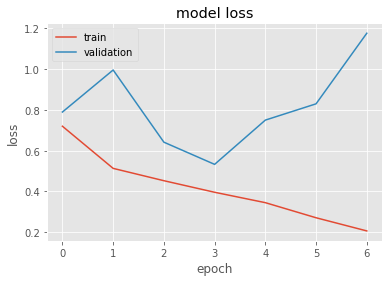

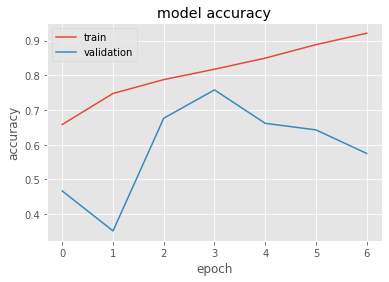

In [61]:
# Plots
loss_curve_plot(model_RMS_fit)
accuracy_curve_plot(model_RMS_fit)

In [62]:
# Model evaluation

model_RMS.evaluate(valid_generator)

188/188 [==============================] - 54s 283ms/step - loss: 1.1763 - accuracy: 0.5749


[1.1762982606887817, 0.5749333500862122]

In [63]:
# Build predictions

predictions_RMS = model_RMS.predict(test_generator,
                      verbose=1)

207/250 [=======================>......] - ETA: 18s

c:\Users\Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 [==============================] - 103s 413ms/step


In [64]:
# Transform model predictions' continuos output into binary categories

bin_predictions_RMS = pred_to_bin(predictions_RMS)

# Associate binary number to true_label

control_df_RMS = build_controlDF(control_df, bin_predictions_RMS)


In [65]:
# Store model 1 metrics in the comparison frame

comparison_frame.loc["RMS"] = evaluate_model(control_df_RMS.true_bin, control_df_RMS.prediction_binary)
comparison_frame

,Accuracy,F1_Score,Precision,Recall,Roc Score
1,0.717990,0.714384,0.729583,0.717990,0.717990
2,0.801697,0.798160,0.824433,0.801697,0.801697
3,0.850352,0.850218,0.851612,0.850352,0.850352
4,0.494878,0.378043,0.479397,0.494878,0.494878
5,0.839309,0.839208,0.840157,0.839309,0.839309
6,0.712868,0.706701,0.732416,0.712868,0.712868


### Model ADAM

In [10]:
# First model with one basic convolutional layer
model_adam = Sequential()

model_adam.add(Conv2D(32, (3, 3), input_shape = image_size))  #Basic convolutional for low level feature detection
model_adam.add(Activation('relu'))
model_adam.add(MaxPooling2D(pool_size=(2, 2)))  # Focus on important features

model_adam.add(Flatten())
model_adam.add(Dense(256))
model_adam.add(Activation('relu'))

model_adam.add(Dense(1))
model_adam.add(Activation('sigmoid'))

model_adam.summary()

# Compile model

model_adam.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 activation (Activation)     (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 76832)             0         
                                                                 
 dense (Dense)               (None, 256)               19669248  
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                        

In [11]:
# Model fit

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model_adam_checkpoint = ModelCheckpoint("model_adam", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

model_adam_fit =  model_adam.fit(train_generator,
            validation_data=valid_generator,
            epochs = 8, 
            use_multiprocessing=False, 
            verbose = 1,
            callbacks=[callback, model_adam_checkpoint]
)

Epoch 1/8
375/375 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.6982
Epoch 1: val_accuracy improved from -inf to 0.38480, saving model to Model1


INFO:tensorflow:Assets written to: Model1\assets


INFO:tensorflow:Assets written to: Model1\assets


375/375 [==============================] - 526s 1s/step - loss: 0.5995 - accuracy: 0.6982 - val_loss: 0.8838 - val_accuracy: 0.3848
Epoch 2/8
375/375 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.7932
Epoch 2: val_accuracy improved from 0.38480 to 0.72187, saving model to Model1


INFO:tensorflow:Assets written to: Model1\assets


INFO:tensorflow:Assets written to: Model1\assets


375/375 [==============================] - 342s 913ms/step - loss: 0.4447 - accuracy: 0.7932 - val_loss: 0.6037 - val_accuracy: 0.7219
Epoch 3/8
375/375 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.8492
Epoch 3: val_accuracy did not improve from 0.72187
375/375 [==============================] - 345s 917ms/step - loss: 0.3374 - accuracy: 0.8492 - val_loss: 1.0089 - val_accuracy: 0.5723
Epoch 4/8
375/375 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9098
Epoch 4: val_accuracy did not improve from 0.72187
375/375 [==============================] - 299s 798ms/step - loss: 0.2207 - accuracy: 0.9098 - val_loss: 0.9445 - val_accuracy: 0.6691
Epoch 5/8
375/375 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9587
Epoch 5: val_accuracy did not improve from 0.72187
375/375 [==============================] - 340s 908ms/step - loss: 0.1187 - accuracy: 0.9587 - val_loss: 1.4526 - val_accuracy: 0.6059


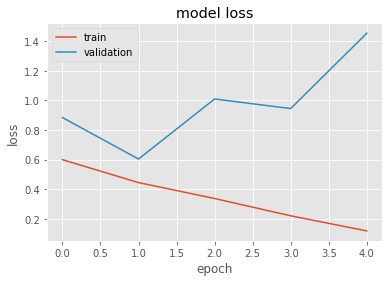

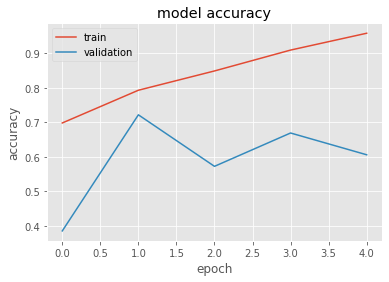

In [12]:
# Loss and visualisation curve visualisation 
loss_curve_plot(model_adam_fit)
accuracy_curve_plot(model_adam_fit)

In [13]:
# Model evaluation

model_adam.evaluate(valid_generator)

188/188 [==============================] - 19s 102ms/step - loss: 1.4526 - accuracy: 0.6059


[1.4525974988937378, 0.6058666706085205]

In [14]:
# Build predictions

predictions_adam = model_adam.predict(test_generator,
                      verbose=1)

207/250 [=======================>......] - ETA: 18s

c:\Users\Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 [==============================] - 117s 463ms/step


In [16]:
# Transform model predictions' continuos output into binary categories

bin_predictions_adam = pred_to_bin(predictions_adam)

# Associate binary number to true_label

control_df_adam = build_controlDF(control_df, bin_predictions_adam)


In [18]:
# Store model 1 metrics in the comparison frame

comparison_frame.loc["adam"] = evaluate_model(control_df_adam.true_bin, control_df_adam.prediction_binary)
comparison_frame

,Accuracy,F1_Score,Precision,Recall,Roc Score
1,0.71799,0.714384,0.729583,0.71799,0.71799


# Model 2

In [19]:
# Adding complexity to the model

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), input_shape = image_size))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(128, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))



model_2.add(Flatten())  
model_2.add(Dense(256, activation='relu'))
 
model_2.add(Flatten())  
model_2.add(Dense(512, activation='relu'))

model_2.add(Dense(1, activation="sigmoid"))

# Summary 

model_2.summary()

# Compiling
model_2.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 activation_3 (Activation)   (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 activation_4 (Activation)   (None, 47, 47, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                  

In [20]:
# Model fit
model2_checkpoint = ModelCheckpoint("Model2", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")


model_2_fit =  model_2.fit(train_generator,
            validation_data=valid_generator,
            epochs = 8, 
            use_multiprocessing=False, 
            verbose = 1,
            callbacks=[callback, model2_checkpoint]
)

Epoch 1/8
375/375 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.6742
Epoch 1: val_accuracy improved from -inf to 0.49973, saving model to Model2


INFO:tensorflow:Assets written to: Model2\assets


INFO:tensorflow:Assets written to: Model2\assets


375/375 [==============================] - 504s 1s/step - loss: 0.5936 - accuracy: 0.6742 - val_loss: 0.8475 - val_accuracy: 0.4997
Epoch 2/8
375/375 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.7858
Epoch 2: val_accuracy improved from 0.49973 to 0.72320, saving model to Model2


INFO:tensorflow:Assets written to: Model2\assets


INFO:tensorflow:Assets written to: Model2\assets


375/375 [==============================] - 324s 865ms/step - loss: 0.4558 - accuracy: 0.7858 - val_loss: 0.5917 - val_accuracy: 0.7232
Epoch 3/8
375/375 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8193
Epoch 3: val_accuracy did not improve from 0.72320
375/375 [==============================] - 291s 775ms/step - loss: 0.4017 - accuracy: 0.8193 - val_loss: 0.7393 - val_accuracy: 0.6144
Epoch 4/8
375/375 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8513
Epoch 4: val_accuracy did not improve from 0.72320
375/375 [==============================] - 306s 815ms/step - loss: 0.3342 - accuracy: 0.8513 - val_loss: 0.6507 - val_accuracy: 0.6952
Epoch 5/8
375/375 [==============================] - ETA: 0s - loss: 0.2717 - accuracy: 0.8832
Epoch 5: val_accuracy did not improve from 0.72320
375/375 [==============================] - 301s 802ms/step - loss: 0.2717 - accuracy: 0.8832 - val_loss: 0.7937 - val_accuracy: 0.6600


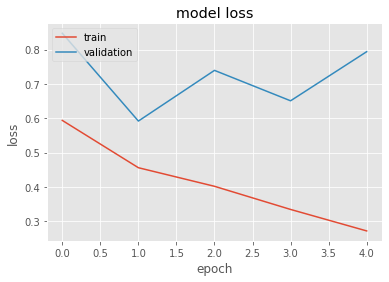

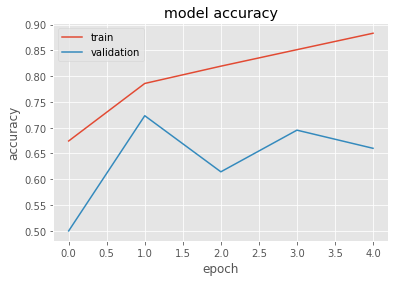

In [21]:
# Loss curve visualisation 

loss_curve_plot(model_2_fit)
accuracy_curve_plot(model_2_fit)

In [22]:
# Model evaluation

model_2.evaluate(valid_generator)

188/188 [==============================] - 21s 111ms/step - loss: 0.7937 - accuracy: 0.6600


[0.7937229871749878, 0.6600000262260437]

In [23]:
# Build predictions

predictions_2 = model_2.predict(test_generator,
                      verbose=1)

207/250 [=======================>......] - ETA: 14s

c:\Users\Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 [==============================] - 81s 322ms/step


In [24]:
# Transform model predictions' continuos output into binary categories

bin_predictions_2 = pred_to_bin(predictions_2)

# Associate binary number to true_label

control_df_2 = build_controlDF(control_df, bin_predictions_2)


In [25]:
# Store model 2 results to comparison frame

comparison_frame.loc[2] = evaluate_model(control_df_2.true_bin, control_df_2.prediction_binary)
comparison_frame

,Accuracy,F1_Score,Precision,Recall,Roc Score
1,0.717990,0.714384,0.729583,0.717990,0.717990
2,0.801697,0.798160,0.824433,0.801697,0.801697


## Model 3

In [26]:
# Adding complexity

model_3 = Sequential()

model_3.add(Conv2D(32, (3, 3), input_shape = image_size))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(128, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(256, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))



model_3.add(Flatten())  
model_3.add(Dense(512, activation='relu'))
 
model_3.add(Flatten())  
model_3.add(Dense(512, activation='relu'))

model_3.add(Flatten())  
model_3.add(Dense(512, activation='relu'))

model_3.add(Dense(1, activation="sigmoid"))

# Summary 

model_3.summary()

# Compiling
model_3.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 activation_7 (Activation)   (None, 47, 47, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                  

In [27]:
# Model fit

model3_checkpoint = ModelCheckpoint("Model3", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

model_3_fit =  model_3.fit(train_generator,
            validation_data=valid_generator,
            epochs = 8, 
            use_multiprocessing=False, 
            verbose = 1,
            callbacks=[callback, model3_checkpoint]
)

Epoch 1/8
375/375 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.6553
Epoch 1: val_accuracy improved from -inf to 0.32213, saving model to Model3


INFO:tensorflow:Assets written to: Model3\assets


INFO:tensorflow:Assets written to: Model3\assets


375/375 [==============================] - 344s 908ms/step - loss: 0.6277 - accuracy: 0.6553 - val_loss: 0.9410 - val_accuracy: 0.3221
Epoch 2/8
375/375 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.7411
Epoch 2: val_accuracy improved from 0.32213 to 0.60933, saving model to Model3


INFO:tensorflow:Assets written to: Model3\assets


INFO:tensorflow:Assets written to: Model3\assets


375/375 [==============================] - 403s 1s/step - loss: 0.5217 - accuracy: 0.7411 - val_loss: 0.6533 - val_accuracy: 0.6093
Epoch 3/8
375/375 [==============================] - ETA: 0s - loss: 0.4291 - accuracy: 0.8025
Epoch 3: val_accuracy improved from 0.60933 to 0.63440, saving model to Model3


INFO:tensorflow:Assets written to: Model3\assets


INFO:tensorflow:Assets written to: Model3\assets


375/375 [==============================] - 342s 911ms/step - loss: 0.4291 - accuracy: 0.8025 - val_loss: 0.6325 - val_accuracy: 0.6344
Epoch 4/8
375/375 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.8405
Epoch 4: val_accuracy improved from 0.63440 to 0.80720, saving model to Model3


INFO:tensorflow:Assets written to: Model3\assets


INFO:tensorflow:Assets written to: Model3\assets


375/375 [==============================] - 336s 896ms/step - loss: 0.3628 - accuracy: 0.8405 - val_loss: 0.4111 - val_accuracy: 0.8072
Epoch 5/8
375/375 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.8737
Epoch 5: val_accuracy did not improve from 0.80720
375/375 [==============================] - 353s 940ms/step - loss: 0.2910 - accuracy: 0.8737 - val_loss: 0.9656 - val_accuracy: 0.6013
Epoch 6/8
375/375 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.8975
Epoch 6: val_accuracy improved from 0.80720 to 0.82320, saving model to Model3


INFO:tensorflow:Assets written to: Model3\assets


INFO:tensorflow:Assets written to: Model3\assets


375/375 [==============================] - 355s 945ms/step - loss: 0.2422 - accuracy: 0.8975 - val_loss: 0.4160 - val_accuracy: 0.8232
Epoch 7/8
375/375 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9222
Epoch 7: val_accuracy did not improve from 0.82320
375/375 [==============================] - 345s 919ms/step - loss: 0.1851 - accuracy: 0.9222 - val_loss: 0.4220 - val_accuracy: 0.8067
Epoch 8/8
375/375 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9445
Epoch 8: val_accuracy did not improve from 0.82320
375/375 [==============================] - 345s 921ms/step - loss: 0.1368 - accuracy: 0.9445 - val_loss: 0.6356 - val_accuracy: 0.8128


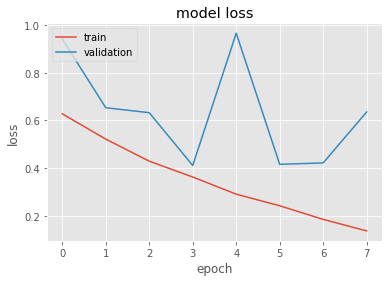

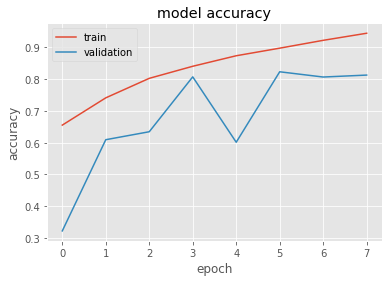

In [28]:
# Loss curve visualisation 

loss_curve_plot(model_3_fit)
accuracy_curve_plot(model_3_fit)

In [29]:
# Model evaluation

model_3.evaluate(valid_generator)

188/188 [==============================] - 23s 122ms/step - loss: 0.6356 - accuracy: 0.8128


[0.6355986595153809, 0.8127999901771545]

In [30]:
# Build predictions

predictions_3 = model_3.predict(test_generator,
                      verbose=1)

208/250 [=======================>......] - ETA: 11s

c:\Users\Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 [==============================] - 63s 253ms/step


In [31]:
# Transform model predictions' continuos output into binary categories

bin_predictions_3 = pred_to_bin(predictions_3)

# Associate binary number to true_label

control_df_3 = build_controlDF(control_df, bin_predictions_3)


In [32]:
# Store model 3 results to comparison frame

comparison_frame.loc[3] = evaluate_model(control_df_3.true_bin, control_df_3.prediction_binary)
comparison_frame

,Accuracy,F1_Score,Precision,Recall,Roc Score
1,0.717990,0.714384,0.729583,0.717990,0.717990
2,0.801697,0.798160,0.824433,0.801697,0.801697
3,0.850352,0.850218,0.851612,0.850352,0.850352


## Model 4

In [33]:
# Adding data augmentation

# Setup generator

image_generator = ImageDataGenerator(rescale=1/255, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, validation_split=0.2) # rescaling data to 0 and 1, 1/255 due to the fact that it is RGB data and using data augmentation

# Flow from dataframe function setup

train_generator = image_generator.flow_from_dataframe(
                                            dataframe=train_df,
                                            directory="./train",
                                            x_col="id",
                                            y_col="label",
                                            subset="training",
                                            batch_size=40,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=image_size[0:2],
                                            color_mode="rgb")

valid_generator = image_generator.flow_from_dataframe(
                                                    dataframe=train_df,
                                                    directory="./train",
                                                    x_col="id",
                                                    y_col="label",
                                                    subset="validation",
                                                    batch_size=20,
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode="binary",
                                                    target_size=image_size[0:2],
                                                    color_mode="rgb")

test_image_generator = ImageDataGenerator(rescale=1/255)

test_generator= test_image_generator.flow_from_dataframe(
                                                    dataframe=test_df,
                                                    directory="./test",
                                                    x_col="id",
                                                    y_col=None,
                                                    batch_size=25,
                                                    seed=42,
                                                    shuffle=False,
                                                    class_mode=None,
                                                    target_size=image_size[0:2],
                                                    color_mode="rgb")


Found 15000 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Found 6248 validated image filenames.


In [34]:
# Adding data augmentation

model_4 = Sequential()

model_4.add(Conv2D(32, (3, 3), input_shape = image_size))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(64, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(128, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(256, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))



model_4.add(Flatten())  
model_4.add(Dense(512, activation='relu'))
 
model_4.add(Flatten())  
model_4.add(Dense(512, activation='relu'))

model_4.add(Flatten())  
model_4.add(Dense(512, activation='relu'))

model_4.add(Dense(1, activation="sigmoid"))

# Summary 

model_4.summary()

# Compiling
model_4.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 activation_10 (Activation)  (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 activation_11 (Activation)  (None, 47, 47, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                  

In [35]:
# Model fit

model4_checkpoint = ModelCheckpoint("Model4", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

model_4_fit =  model_3.fit(train_generator,
            validation_data=valid_generator,
            epochs = 8, 
            use_multiprocessing=False, 
            verbose = 1,
            callbacks=[callback, model4_checkpoint]
)

Epoch 1/8
375/375 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8578
Epoch 1: val_accuracy improved from -inf to 0.91440, saving model to Model4


INFO:tensorflow:Assets written to: Model4\assets


INFO:tensorflow:Assets written to: Model4\assets


375/375 [==============================] - 373s 993ms/step - loss: 0.3250 - accuracy: 0.8578 - val_loss: 0.2115 - val_accuracy: 0.9144
Epoch 2/8
375/375 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8723
Epoch 2: val_accuracy did not improve from 0.91440
375/375 [==============================] - 369s 983ms/step - loss: 0.2963 - accuracy: 0.8723 - val_loss: 0.5328 - val_accuracy: 0.7488
Epoch 3/8
375/375 [==============================] - ETA: 0s - loss: 0.2713 - accuracy: 0.8817
Epoch 3: val_accuracy did not improve from 0.91440
375/375 [==============================] - 368s 980ms/step - loss: 0.2713 - accuracy: 0.8817 - val_loss: 0.7220 - val_accuracy: 0.6992
Epoch 4/8
375/375 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.8875
Epoch 4: val_accuracy did not improve from 0.91440
375/375 [==============================] - 369s 984ms/step - loss: 0.2617 - accuracy: 0.8875 - val_loss: 0.4810 - val_accuracy: 0.7867


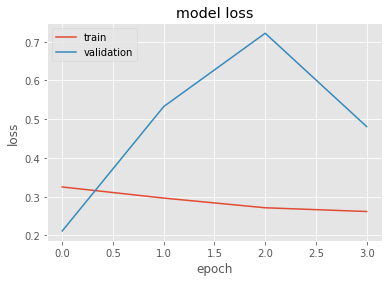

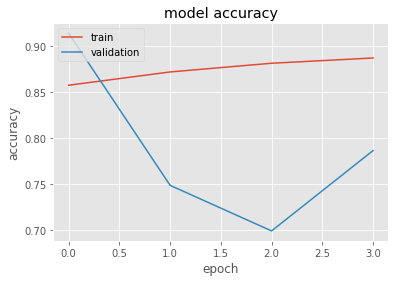

In [36]:
# Loss curve visualisation 

loss_curve_plot(model_4_fit)
accuracy_curve_plot(model_4_fit)

In [37]:
# Model evaluation

model_4.evaluate(valid_generator)

188/188 [==============================] - 38s 197ms/step - loss: 0.6894 - accuracy: 0.9197


[0.6894381046295166, 0.9197333455085754]

In [38]:
# Build predictions

predictions_4 = model_4.predict(test_generator,
                      verbose=1)

207/250 [=======================>......] - ETA: 8s

c:\Users\Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 [==============================] - 49s 194ms/step


In [39]:
# Transform model predictions' continuos output into binary categories

bin_predictions_4 = pred_to_bin(predictions_4)

# Associate binary number to true_label

control_df_4 = build_controlDF(control_df, bin_predictions_4)


In [40]:
# Store model 3 results to comparison frame

comparison_frame.loc[4] = evaluate_model(control_df_4.true_bin, control_df_4.prediction_binary)
comparison_frame

,Accuracy,F1_Score,Precision,Recall,Roc Score
1,0.717990,0.714384,0.729583,0.717990,0.717990
2,0.801697,0.798160,0.824433,0.801697,0.801697
3,0.850352,0.850218,0.851612,0.850352,0.850352
4,0.494878,0.378043,0.479397,0.494878,0.494878


## MODEL 5


In [41]:
# Setup generator

image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) # rescaling data to 0 and 1, 1/255 due to the fact that it is RGB data

# Flow from dataframe function setup

train_generator = image_generator.flow_from_dataframe(
                                            dataframe=train_df,
                                            directory="./train",
                                            x_col="id",
                                            y_col="label",
                                            subset="training",
                                            batch_size=40,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=image_size[0:2],
                                            color_mode="rgb")

valid_generator=image_generator.flow_from_dataframe(
                                                    dataframe=train_df,
                                                    directory="./train",
                                                    x_col="id",
                                                    y_col="label",
                                                    subset="validation",
                                                    batch_size=20,
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode="binary",
                                                    target_size=image_size[0:2],
                                                    color_mode="rgb")

test_image_generator = ImageDataGenerator(rescale=1/255)

test_generator=test_image_generator.flow_from_dataframe(
                                                    dataframe=test_df,
                                                    directory="./test",
                                                    x_col="id",
                                                    y_col=None,
                                                    batch_size=25,
                                                    seed=42,
                                                    shuffle=False,
                                                    class_mode=None,
                                                    target_size=image_size[0:2],
                                                    color_mode="rgb")

Found 15000 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Found 6248 validated image filenames.


In [51]:
# Adding  regularization with batch normalization and dropout

model_5 = Sequential()

model_5.add(Conv2D(32, (3, 3), input_shape = image_size))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Conv2D(64, (3, 3)))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Conv2D(128, (3, 3)))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.1))

model_5.add(Conv2D(256, (3, 3)))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))



model_5.add(Flatten())  
model_5.add(Dense(512, activation='relu'))
 
model_5.add(Flatten())  
model_5.add(Dense(512, activation='relu'))
model_5.add(Dropout(0.1))

model_5.add(Flatten())  
model_5.add(Dense(512, activation='relu'))
model_5.add(Dropout(0.2))

model_5.add(Dense(1, activation="sigmoid"))

# Summary 

model_5.summary()

# Compiling
model_5.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_220 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 activation_221 (Activation)  (None, 98, 98, 32)       0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_221 (Conv2D)         (None, 47, 47, 64)        18496     
                                                                 
 activation_222 (Activation)  (None, 47, 47, 64)       0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                 

In [52]:
# Model fit

model5_checkpoint = ModelCheckpoint("Model5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

model_5_fit =  model_5.fit(train_generator,
            validation_data=valid_generator,
            epochs = 8, 
            use_multiprocessing=False, 
            verbose = 1,
            callbacks=[callback, model5_checkpoint]
)

Epoch 1/8
375/375 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.6832
Epoch 1: val_accuracy improved from -inf to 0.88747, saving model to Model5


INFO:tensorflow:Assets written to: Model5\assets


INFO:tensorflow:Assets written to: Model5\assets


375/375 [==============================] - 421s 1s/step - loss: 0.5919 - accuracy: 0.6832 - val_loss: 0.5987 - val_accuracy: 0.8875
Epoch 2/8
375/375 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.7675
Epoch 2: val_accuracy did not improve from 0.88747
375/375 [==============================] - 382s 1s/step - loss: 0.4847 - accuracy: 0.7675 - val_loss: 0.5734 - val_accuracy: 0.6861
Epoch 3/8
375/375 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8132
Epoch 3: val_accuracy did not improve from 0.88747
375/375 [==============================] - 415s 1s/step - loss: 0.4120 - accuracy: 0.8132 - val_loss: 0.3227 - val_accuracy: 0.8469
Epoch 4/8
375/375 [==============================] - ETA: 0s - loss: 0.3643 - accuracy: 0.8419
Epoch 4: val_accuracy did not improve from 0.88747
375/375 [==============================] - 463s 1s/step - loss: 0.3643 - accuracy: 0.8419 - val_loss: 0.4042 - val_accuracy: 0.8061


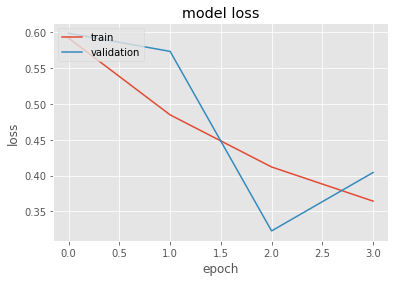

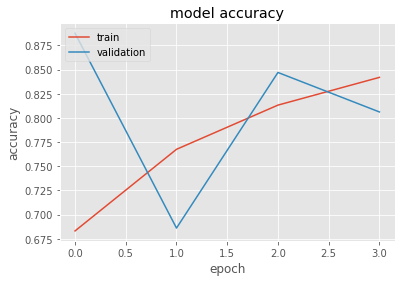

In [53]:
# Loss curve visualisation 

loss_curve_plot(model_5_fit)
accuracy_curve_plot(model_5_fit)

In [54]:
# Model evaluation

model_5.evaluate(valid_generator)

188/188 [==============================] - 24s 127ms/step - loss: 0.4042 - accuracy: 0.8061


[0.40422573685646057, 0.8061333298683167]

In [55]:
# Build predictions

predictions_5 = model_5.predict(test_generator,
                      verbose=1)

207/250 [=======================>......] - ETA: 14s

c:\Users\Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 [==============================] - 86s 343ms/step


In [56]:
# Transform model predictions' continuos output into binary categories

bin_predictions_5 = pred_to_bin(predictions_5)

# Associate binary number to true_label

control_df_5 = build_controlDF(control_df, bin_predictions_5)


In [57]:
# Store model 4 results to comparison frame

comparison_frame.loc[5] = evaluate_model(control_df_5.true_bin, control_df_5.prediction_binary)
comparison_frame

,Accuracy,F1_Score,Precision,Recall,Roc Score
1,0.717990,0.714384,0.729583,0.717990,0.717990
2,0.801697,0.798160,0.824433,0.801697,0.801697
3,0.850352,0.850218,0.851612,0.850352,0.850352
4,0.494878,0.378043,0.479397,0.494878,0.494878
5,0.839309,0.839208,0.840157,0.839309,0.839309


## Model CV

In [ ]:
from sklearn.model_selection import KFold, train_test_split
import pickle

train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.12, 
                                   random_state = 123)

folds = KFold(n_splits=5, shuffle = True, random_state = 123)


In [ ]:
# Definition of cross validation model

image_size = (180,180,3)

def model_cv_definition():
        
    model_cv = Sequential()

    model_cv.add(Conv2D(32, (3, 3), input_shape = image_size))
    model_cv.add(Activation('relu'))
    model_cv.add(MaxPooling2D(pool_size=(2, 2)))

    model_cv.add(Conv2D(64, (3, 3)))
    model_cv.add(Activation('relu'))
    model_cv.add(MaxPooling2D(pool_size=(2, 2)))

    model_cv.add(Conv2D(128, (3, 3)))
    model_cv.add(Activation('relu'))
    model_cv.add(MaxPooling2D(pool_size=(2, 2)))

    model_cv.add(Conv2D(256, (3, 3)))
    model_cv.add(Activation('relu'))
    model_cv.add(MaxPooling2D(pool_size=(2, 2)))



    model_cv.add(Flatten())  
    model_cv.add(Dense(512, activation='relu'))
    
    model_cv.add(Flatten())  
    model_cv.add(Dense(512, activation='relu'))

    model_cv.add(Flatten())  
    model_cv.add(Dense(512, activation='relu'))

    model_cv.add(Dense(1, activation="sigmoid"))

    return model_cv
    

In [ ]:
# Define generators
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) # rescaling data to 0 and 1, 1/255 due to the fact that it is RGB data
test_image_generator = ImageDataGenerator(rescale=1/255)
count = 1 # To keep track of the fold count

# Define checkpoint for the model

model_cv_checkpoint = ModelCheckpoint("Modelcv", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# Cross validation

for train_index, inner_test_index in folds.split(train_df):
    training_data = train_df.iloc[train_index]
    inner_test_data = train_df.iloc[inner_test_index]


    train_generator = image_generator.flow_from_dataframe(
                                            dataframe=training_data,
                                            directory="./train",
                                            x_col="id",
                                            y_col="label",
                                            subset="training",
                                            batch_size=40,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="binary",
                                            target_size=image_size[0:2],
                                            color_mode="rgb")
    
    inner_test = image_generator.flow_from_dataframe(
                                                    dataframe=training_data,
                                                    directory="./train",
                                                    x_col="id",
                                                    y_col="label",
                                                    subset="validation",
                                                    batch_size=20,
                                                    seed=42,
                                                    shuffle=True,
                                                    class_mode="binary",
                                                    target_size=image_size[0:2],
                                                    color_mode="rgb")

    
    outer_test = test_image_generator.flow_from_dataframe(
                                                    dataframe=test_df,
                                                    directory="./test",
                                                    x_col="id",
                                                    y_col=None,
                                                    batch_size=25,
                                                    seed=42,
                                                    shuffle=False,
                                                    class_mode=None,
                                                    target_size=image_size[0:2],
                                                    color_mode="rgb")



    # Define model 

    model_cv = model_cv_definition()

    # Compile the model

    model_cv.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])




    # Model FIT
    
    model_cv_fit =  model_cv.fit(train_generator,
            validation_data=inner_test,
            epochs = 8, 
            use_multiprocessing=False, 
            workers = 20,
            verbose = 1,
            callbacks=[model_cv_checkpoint]
)

    # Free GPU 

    tf.keras.backend.clear_session()


Found 8177 validated image filenames belonging to 2 classes.
Found 2044 validated image filenames belonging to 2 classes.
Found 6248 validated image filenames.
Epoch 1/8
205/205 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.5133
Epoch 1: val_accuracy improved from -inf to 0.49609, saving model to Modelcv


INFO:tensorflow:Assets written to: Modelcv\assets


INFO:tensorflow:Assets written to: Modelcv\assets


205/205 [==============================] - 733s 4s/step - loss: 0.6943 - accuracy: 0.5133 - val_loss: 0.6932 - val_accuracy: 0.4961
Epoch 2/8
205/205 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.5377
Epoch 2: val_accuracy improved from 0.49609 to 0.60665, saving model to Modelcv


INFO:tensorflow:Assets written to: Modelcv\assets


INFO:tensorflow:Assets written to: Modelcv\assets


205/205 [==============================] - 677s 3s/step - loss: 0.6873 - accuracy: 0.5377 - val_loss: 0.6675 - val_accuracy: 0.6067
Epoch 3/8
205/205 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.6118
Epoch 3: val_accuracy improved from 0.60665 to 0.66487, saving model to Modelcv


INFO:tensorflow:Assets written to: Modelcv\assets


INFO:tensorflow:Assets written to: Modelcv\assets


205/205 [==============================] - 665s 3s/step - loss: 0.6549 - accuracy: 0.6118 - val_loss: 0.6037 - val_accuracy: 0.6649
Epoch 4/8
205/205 [==============================] - ETA: 0s - loss: 0.5817 - accuracy: 0.6957
Epoch 4: val_accuracy improved from 0.66487 to 0.72603, saving model to Modelcv


INFO:tensorflow:Assets written to: Modelcv\assets


INFO:tensorflow:Assets written to: Modelcv\assets


205/205 [==============================] - 635s 3s/step - loss: 0.5817 - accuracy: 0.6957 - val_loss: 0.5798 - val_accuracy: 0.7260
Epoch 5/8
205/205 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.7516
Epoch 5: val_accuracy improved from 0.72603 to 0.77348, saving model to Modelcv


INFO:tensorflow:Assets written to: Modelcv\assets


INFO:tensorflow:Assets written to: Modelcv\assets


205/205 [==============================] - 650s 3s/step - loss: 0.5134 - accuracy: 0.7516 - val_loss: 0.5005 - val_accuracy: 0.7735
Epoch 6/8
205/205 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.7930
Epoch 6: val_accuracy improved from 0.77348 to 0.78131, saving model to Modelcv


INFO:tensorflow:Assets written to: Modelcv\assets


INFO:tensorflow:Assets written to: Modelcv\assets


205/205 [==============================] - 619s 3s/step - loss: 0.4423 - accuracy: 0.7930 - val_loss: 0.4723 - val_accuracy: 0.7813
Epoch 7/8
205/205 [==============================] - ETA: 0s - loss: 0.3958 - accuracy: 0.8212
Epoch 7: val_accuracy improved from 0.78131 to 0.79795, saving model to Modelcv


INFO:tensorflow:Assets written to: Modelcv\assets


INFO:tensorflow:Assets written to: Modelcv\assets


205/205 [==============================] - 616s 3s/step - loss: 0.3958 - accuracy: 0.8212 - val_loss: 0.4749 - val_accuracy: 0.7979
Epoch 8/8
205/205 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8480
Epoch 8: val_accuracy improved from 0.79795 to 0.81507, saving model to Modelcv


INFO:tensorflow:Assets written to: Modelcv\assets


INFO:tensorflow:Assets written to: Modelcv\assets


208/250 [=======================>......] - ETA: 12s - loss: 0.0000e+00 - accuracy: 0.0000e+00

c:\Users\Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 [==============================] - 73s 288ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Found 8177 validated image filenames belonging to 2 classes.
Found 2044 validated image filenames belonging to 2 classes.
Found 6248 validated image filenames.
Epoch 1/8
205/205 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.5105
Epoch 1: val_accuracy did not improve from 0.81507
205/205 [==============================] - 629s 3s/step - loss: 0.6942 - accuracy: 0.5105 - val_loss: 0.6932 - val_accuracy: 0.4936
Epoch 2/8
205/205 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.5249
Epoch 2: val_accuracy did not improve from 0.81507
205/205 [==============================] - 617s 3s/step - loss: 0.6885 - accuracy: 0.5249 - val_loss: 0.6836 - val_accuracy: 0.5680
Epoch 3/8
205/205 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.6003
Epoch 3: val_accuracy did not improve from 0.81507
205/205 [=============================

c:\Users\Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 [==============================] - 31s 121ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Found 8178 validated image filenames belonging to 2 classes.
Found 2044 validated image filenames belonging to 2 classes.
Found 6248 validated image filenames.
Epoch 1/8
205/205 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5067
Epoch 1: val_accuracy did not improve from 0.81507
205/205 [==============================] - 625s 3s/step - loss: 0.6929 - accuracy: 0.5067 - val_loss: 0.6933 - val_accuracy: 0.4990
Epoch 2/8
205/205 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.5300
Epoch 2: val_accuracy did not improve from 0.81507
205/205 [==============================] - 625s 3s/step - loss: 0.6885 - accuracy: 0.5300 - val_loss: 0.6887 - val_accuracy: 0.5426
Epoch 3/8
205/205 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.5896
Epoch 3: val_accuracy did not improve from 0.81507
205/205 [=============================

KeyboardInterrupt: 

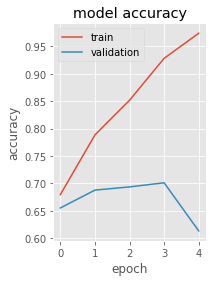

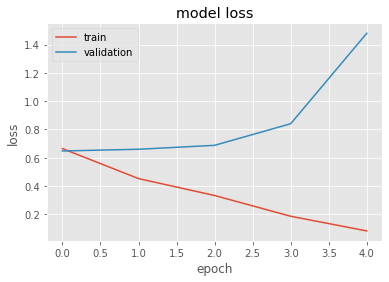

In [ ]:
# Loss and accuracy curve visualisation

loss_curve_plot(model_cv_fit)
accuracy_curve_plot(model_cv_fit)

In [ ]:
# Build predictions

predictions_cv = model_cv.predict(test_generator,
                      verbose=1)

207/250 [=======================>......] - ETA: 27s

c:\Users\Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 [==============================] - 157s 627ms/step


In [ ]:
# Transform model predictions' continuos output into binary categories

bin_predictions_cv = pred_to_bin(predictions_cv)

# Associate binary number to true_label

control_df_cv = build_controlDF(control_df, bin_predictions_cv)

In [ ]:
# Store model 2 results to comparison frame

comparison_frame.loc["cv"] = evaluate_model(control_df_cv.true_bin, control_df_cv.prediction_binary)
comparison_frame

,Accuracy,F1_Score,Precision,Recall,Roc Score
1,0.705986,0.704946,0.708933,0.705986,0.705986
2,0.787132,0.787031,0.787677,0.787132,0.787132
3,0.811620,0.809435,0.826597,0.811620,0.811620
cv,0.737356,0.732878,0.754418,0.737356,0.737356
